# vLife Virtusa
## Competitor Analyzer
### Usecase Description
_Solution aims to Find Internal Competitions for pharmaceutical stores using the sales data,distance between the stores and store size.Complete ML Pipeline is build initializing from EDA to Model training._


### Dataset Source
Data for this usecase can be found [here](https://www.kaggle.com/c/rossmann-store-sales/data).

### Dataset Description
* Files
   - train.csv - historical data including Sales
   - test.csv - historical data excluding Sales
   - sample_submission.csv - a sample submission file in the correct format
   - store.csv - supplemental information about the stores
* Data fields

 > Most of the fields are self-explanatory. The following are descriptions for those that aren't.

1. Id - an Id that represents a (Store, Date) duple within the test set
2. Store - a unique Id for each store
3. Sales - the turnover for any given day (this is what you are predicting)
4. Customers - the number of customers on a given day
5. Open - an indicator for whether the store was open: 0 = closed, 1 = open
6. StateHoliday - indicates a state holiday. Normally all stores, with few exceptions, are closed on state holidays. Note that all schools are closed on public holidays and weekends. a = public holiday, b = Easter holiday, c = Christmas, 0 = None
7. SchoolHoliday - indicates if the (Store, Date) was affected by the closure of public schools
8. StoreType - differentiates between 4 different store models: a, b, c, d
9. Assortment - describes an assortment level: a = basic, b = extra, c = extended
10. CompetitionDistance - distance in meters to the nearest competitor store
11. CompetitionOpenSince[Month/Year] - gives the approximate year and month of the time the nearest competitor was opened
12. Promo - indicates whether a store is running a promo on that day
13. Promo2 - Promo2 is a continuing and consecutive promotion for some stores: 0 = store is not participating, 1 = store is participating
14. Promo2Since[Year/Week] - describes the year and calendar week when the store started participating in Promo2
15. PromoInterval - describes the consecutive intervals Promo2 is started, naming the months the promotion is started anew. E.g. "Feb,May,Aug,Nov" means each round starts in February, May, August, November of any given year for that store

#### Import Section

In [1]:
import pandas as pd
from pandas import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn import model_selection
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics


In [2]:
train = pd.read_csv('train.csv', parse_dates = ['Date'], low_memory = False)
train.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


In [3]:
test = pd.read_csv('test.csv', parse_dates = True, low_memory = False)
test.head()

,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday
0,1,1,4,2015-09-17,1.0,1,0,0
1,2,3,4,2015-09-17,1.0,1,0,0
2,3,7,4,2015-09-17,1.0,1,0,0
3,4,8,4,2015-09-17,1.0,1,0,0
4,5,9,4,2015-09-17,1.0,1,0,0


### Exploratory Data Analysis
#### Data Preprocessing & Munging

In [4]:
train['Date']=pd.to_datetime(train['Date'],format='%Y-%m-%d')
train['Date']

0         2015-07-31
1         2015-07-31
2         2015-07-31
3         2015-07-31
4         2015-07-31
5         2015-07-31
6         2015-07-31
7         2015-07-31
8         2015-07-31
9         2015-07-31
10        2015-07-31
11        2015-07-31
12        2015-07-31
13        2015-07-31
14        2015-07-31
15        2015-07-31
16        2015-07-31
17        2015-07-31
18        2015-07-31
19        2015-07-31
20        2015-07-31
21        2015-07-31
22        2015-07-31
23        2015-07-31
24        2015-07-31
25        2015-07-31
26        2015-07-31
27        2015-07-31
28        2015-07-31
29        2015-07-31
             ...    
1017179   2013-01-01
1017180   2013-01-01
1017181   2013-01-01
1017182   2013-01-01
1017183   2013-01-01
1017184   2013-01-01
1017185   2013-01-01
1017186   2013-01-01
1017187   2013-01-01
1017188   2013-01-01
1017189   2013-01-01
1017190   2013-01-01
1017191   2013-01-01
1017192   2013-01-01
1017193   2013-01-01
1017194   2013-01-01
1017195   201

In [5]:
train['Day'] = train['Date'].dt.day
train['Month'] = train['Date'].dt.month
train['Year'] = train['Date'].dt.year
train['MonthYear'] = train['Date'].apply(lambda x : (str(x)[:7]))
train.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Day,Month,Year,MonthYear
0,1,5,2015-07-31,5263,555,1,1,0,1,31,7,2015,2015-07
1,2,5,2015-07-31,6064,625,1,1,0,1,31,7,2015,2015-07
2,3,5,2015-07-31,8314,821,1,1,0,1,31,7,2015,2015-07
3,4,5,2015-07-31,13995,1498,1,1,0,1,31,7,2015,2015-07
4,5,5,2015-07-31,4822,559,1,1,0,1,31,7,2015,2015-07


In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 13 columns):
Store            1017209 non-null int64
DayOfWeek        1017209 non-null int64
Date             1017209 non-null datetime64[ns]
Sales            1017209 non-null int64
Customers        1017209 non-null int64
Open             1017209 non-null int64
Promo            1017209 non-null int64
StateHoliday     1017209 non-null object
SchoolHoliday    1017209 non-null int64
Day              1017209 non-null int64
Month            1017209 non-null int64
Year             1017209 non-null int64
MonthYear        1017209 non-null object
dtypes: datetime64[ns](1), int64(10), object(2)
memory usage: 100.9+ MB


In [7]:
train.drop(['Date'], axis = 1, inplace = True)
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 12 columns):
Store            1017209 non-null int64
DayOfWeek        1017209 non-null int64
Sales            1017209 non-null int64
Customers        1017209 non-null int64
Open             1017209 non-null int64
Promo            1017209 non-null int64
StateHoliday     1017209 non-null object
SchoolHoliday    1017209 non-null int64
Day              1017209 non-null int64
Month            1017209 non-null int64
Year             1017209 non-null int64
MonthYear        1017209 non-null object
dtypes: int64(10), object(2)
memory usage: 93.1+ MB


> StateHoliday has a mixture of "O", 0 and "0", replace these with "0"

In [8]:
train.StateHoliday.replace(["O",0,"0"],['0','0','0'], inplace=True)
train.head()

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Day,Month,Year,MonthYear
0,1,5,5263,555,1,1,0,1,31,7,2015,2015-07
1,2,5,6064,625,1,1,0,1,31,7,2015,2015-07
2,3,5,8314,821,1,1,0,1,31,7,2015,2015-07
3,4,5,13995,1498,1,1,0,1,31,7,2015,2015-07
4,5,5,4822,559,1,1,0,1,31,7,2015,2015-07


In [9]:
test['Date']=pd.to_datetime(test['Date'],format='%Y-%m-%d')

In [10]:
test['Day'] = test['Date'].dt.day
test['Month'] = test['Date'].dt.month
test['Year'] = test['Date'].dt.year
test['MonthYear'] = test['Date'].apply(lambda x : (str(x)[:7]))
test.head()

,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday,Day,Month,Year,MonthYear
0,1,1,4,2015-09-17,1.0,1,0,0,17,9,2015,2015-09
1,2,3,4,2015-09-17,1.0,1,0,0,17,9,2015,2015-09
2,3,7,4,2015-09-17,1.0,1,0,0,17,9,2015,2015-09
3,4,8,4,2015-09-17,1.0,1,0,0,17,9,2015,2015-09
4,5,9,4,2015-09-17,1.0,1,0,0,17,9,2015,2015-09


In [11]:
test.drop(['Id','Date'], axis = 1, inplace = True)
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41088 entries, 0 to 41087
Data columns (total 10 columns):
Store            41088 non-null int64
DayOfWeek        41088 non-null int64
Open             41077 non-null float64
Promo            41088 non-null int64
StateHoliday     41088 non-null object
SchoolHoliday    41088 non-null int64
Day              41088 non-null int64
Month            41088 non-null int64
Year             41088 non-null int64
MonthYear        41088 non-null object
dtypes: float64(1), int64(7), object(2)
memory usage: 3.1+ MB


In [12]:
test['Open'].isnull().sum()

11

In [13]:
test = test.drop(test[(test['Open'].isnull())].index)
test = test.reset_index(drop=True)

In [14]:
test = test.astype({"Open": int})
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41077 entries, 0 to 41076
Data columns (total 10 columns):
Store            41077 non-null int64
DayOfWeek        41077 non-null int64
Open             41077 non-null int64
Promo            41077 non-null int64
StateHoliday     41077 non-null object
SchoolHoliday    41077 non-null int64
Day              41077 non-null int64
Month            41077 non-null int64
Year             41077 non-null int64
MonthYear        41077 non-null object
dtypes: int64(8), object(2)
memory usage: 3.1+ MB


> StateHoliday has a mixture of "O", 0 and "0", replace these with "0"

In [15]:
test.StateHoliday.replace(["O",0,"0"],['0','0','0'], inplace=True)
test.head()

,Store,DayOfWeek,Open,Promo,StateHoliday,SchoolHoliday,Day,Month,Year,MonthYear
0,1,4,1,1,0,0,17,9,2015,2015-09
1,3,4,1,1,0,0,17,9,2015,2015-09
2,7,4,1,1,0,0,17,9,2015,2015-09
3,8,4,1,1,0,0,17,9,2015,2015-09
4,9,4,1,1,0,0,17,9,2015,2015-09


In [16]:
df = train
df.head()

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Day,Month,Year,MonthYear
0,1,5,5263,555,1,1,0,1,31,7,2015,2015-07
1,2,5,6064,625,1,1,0,1,31,7,2015,2015-07
2,3,5,8314,821,1,1,0,1,31,7,2015,2015-07
3,4,5,13995,1498,1,1,0,1,31,7,2015,2015-07
4,5,5,4822,559,1,1,0,1,31,7,2015,2015-07


Text(0.5, 1.0, 'Variation in sales with respect to the month.')

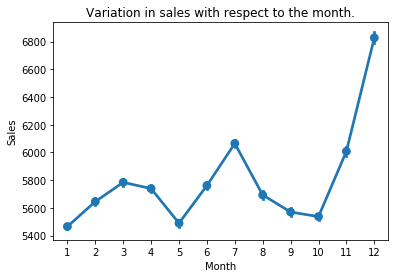

In [17]:
sns.pointplot(x='Month', y='Sales', data=df)
plt.title('Variation in sales with respect to the month.')

Text(0.5, 1.0, 'Variation in sales with respect to the day of the month.')

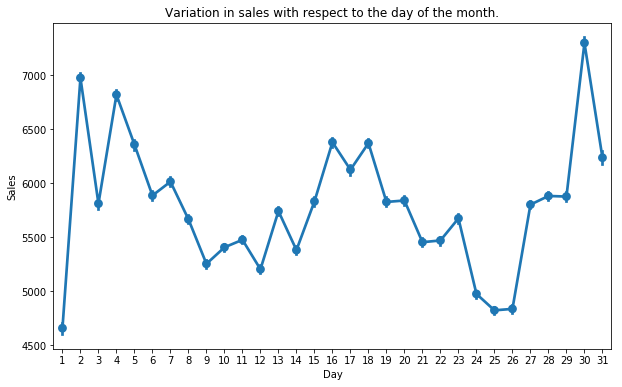

In [18]:
plt.figure(figsize = (10,6))
sns.pointplot(x = 'Day', y = 'Sales', data = df)
plt.title('Variation in sales with respect to the day of the month.')


Text(0.5, 1.0, 'Variation in sales with respect to the day of the week.')

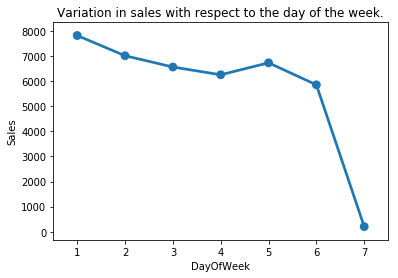

In [19]:
sns.pointplot(x = 'DayOfWeek', y = 'Sales', data = df)
plt.title('Variation in sales with respect to the day of the week.')

Text(0.5, 1.0, 'Stores open for the day')

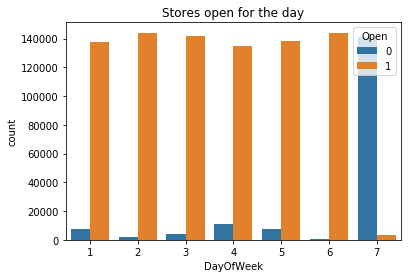

In [20]:
sns.countplot(x = 'DayOfWeek', hue = 'Open', data = df)
plt.title('Stores open for the day')

> Closed stores have zero customers and zero sales. Hence drop them.


In [21]:
print("Number of Closed stores: " ,np.sum([df['Open'] == 0]))
print("No sales: ", np.sum([df['Sales'] == 0]))
df = df.drop(df[(df.Open == 0) & (df.Sales == 0)].index)
df = df.reset_index(drop=True)
df = df.drop(['Open'],axis=1)
df.head()

Number of Closed stores:  172817
No sales:  172871


,Store,DayOfWeek,Sales,Customers,Promo,StateHoliday,SchoolHoliday,Day,Month,Year,MonthYear
0,1,5,5263,555,1,0,1,31,7,2015,2015-07
1,2,5,6064,625,1,0,1,31,7,2015,2015-07
2,3,5,8314,821,1,0,1,31,7,2015,2015-07
3,4,5,13995,1498,1,0,1,31,7,2015,2015-07
4,5,5,4822,559,1,0,1,31,7,2015,2015-07


> Variation between number of customers and amount of sales generated throughout a week 

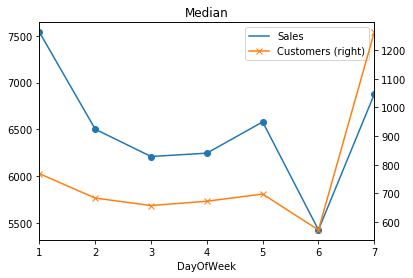

In [22]:
#median sales
median_sales = df.groupby('DayOfWeek')['Sales'].median()
#median customers
median_cust = df.groupby('DayOfWeek')['Customers'].median()

median_sales.plot(legend=True, marker='o',title="Median")
median_cust.plot(legend=True, marker='x', secondary_y=True)

> Variation between number of customers and amount of sales generated throughout the recorded duration 


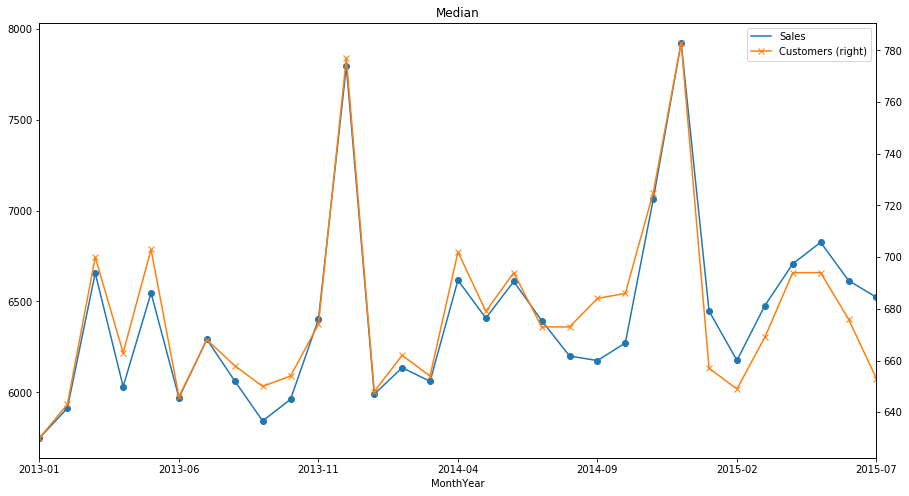

In [23]:
# median sales
median_sales = df.groupby('MonthYear')['Sales'].median()
# median customers
median_cust = df.groupby('MonthYear')['Customers'].median()

plt.figure(figsize=(15,8))
median_sales.plot(legend=True, marker='o',title="Median")
median_cust.plot(legend=True, marker='x', secondary_y=True)

> Relationship of Sales and Customers with State holiday, school holiday and promotion days

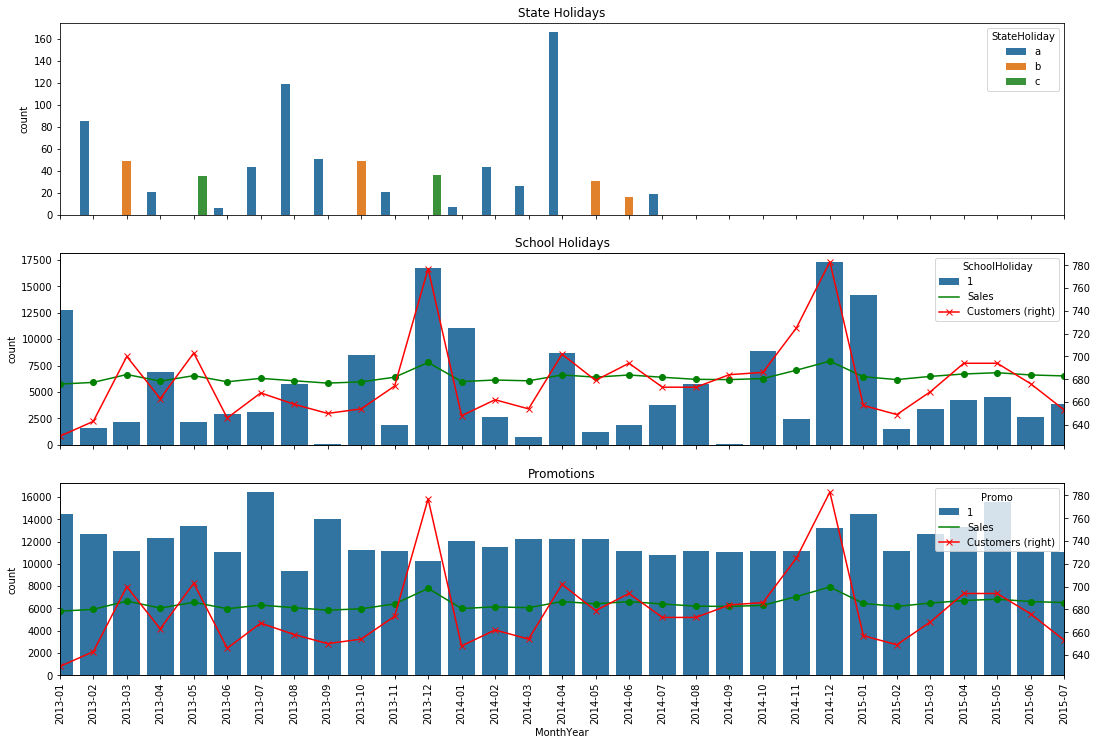

In [24]:
fig, (axis1, axis2, axis3) = plt.subplots(3, 1, sharex=True, figsize=(18,12))

# stateholiday
df.StateHoliday.replace(["O",0,"0"],['0','0','0'], inplace=True)
ax3 = sns.countplot(x='MonthYear', hue='StateHoliday', data=df[df['StateHoliday']!='0'], ax=axis1)
tmp = ax3.set_xticklabels(ax3.get_xticklabels(), rotation=90)
tmp = ax3.set_title('State Holidays')

#schoolholiday 
ax4 = sns.countplot(x='MonthYear', hue='SchoolHoliday', data=df[df['SchoolHoliday']!=0], ax=axis2)
median_sales = df.groupby('MonthYear')['Sales'].median()
median_cust = df.groupby('MonthYear')['Customers'].median()
median_sales.plot(ax=axis2,legend=True, marker='o',title="Median", color='green')
median_cust.plot(ax=axis2,legend=True, marker='x', secondary_y=True, color='red')
tmp = ax4.set_xticklabels(ax4.get_xticklabels(), rotation=90)
tmp = ax4.set_title('School Holidays')

#promotions 
ax5 = sns.countplot(x='MonthYear', hue='Promo', data=df[df["Promo"]!=0], ax=axis3)
median_sales = df.groupby('MonthYear')['Sales'].median()
median_cust = df.groupby('MonthYear')['Customers'].median()
median_sales.plot(ax=axis3,legend=True, marker='o',title="Median", color='green')
median_cust.plot(ax=axis3,legend=True, marker='x', secondary_y=True, color='red')
tmp = ax5.set_xticklabels(ax5.get_xticklabels(), rotation=90)
tmp = ax5.set_title('Promotions')

In [25]:
df['SalesPerCustomer'] = df['Sales']/df['Customers']
df['SalesPerCustomer'].describe()

count    844340.000000
mean          9.493619
std           2.197494
min           0.000000
25%           7.895563
50%           9.250000
75%          10.899729
max          64.957854
Name: SalesPerCustomer, dtype: float64

In [26]:
df['SalesPerCustomer'].isnull().sum()

52

In [27]:
#Remove NANs
df = df[df['SalesPerCustomer'].notnull()] 

> Distribution of stores depending on their sales-per-customer ratio

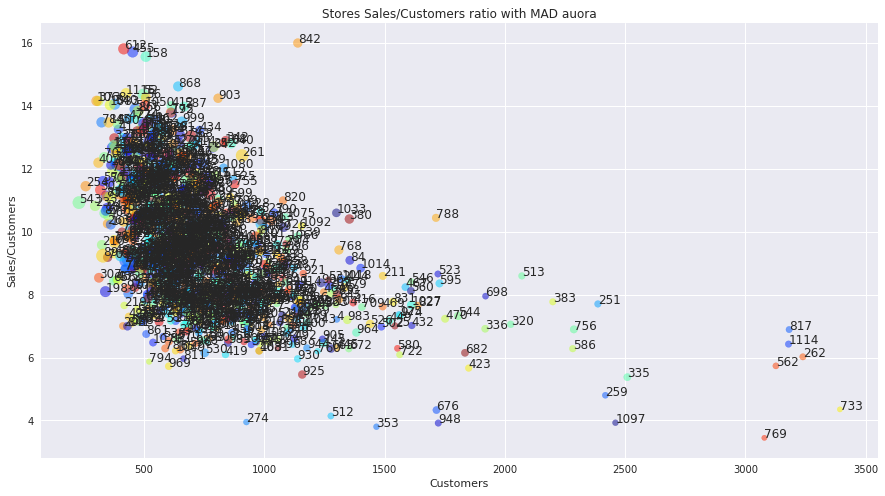

In [28]:
#Calculate median and deviation for each store
SC_perstore = df.groupby('Store')['SalesPerCustomer'].median()
mad_SC_perstore = df.groupby('Store')['SalesPerCustomer'].mad()
C_perstore = df.groupby('Store')['Customers'].median()
mad_C_perstore = df.groupby('Store')['Customers'].mad()

sns.set(font_scale=1)
plt.figure(figsize=(15,8))
colors = np.random.rand(len(SC_perstore))
plt.scatter(C_perstore, SC_perstore, s=mad_SC_perstore*100, c=colors, cmap='jet', alpha=0.5) 
plt.xlabel('Customers')
plt.ylabel('Sales/Customers')
plt.title('Stores Sales/Customers ratio with MAD auora')
for store in SC_perstore.index:
      plt.annotate(store, (C_perstore[store], SC_perstore[store]))

In [29]:
data = pd.DataFrame({'Sales/Customers ratio': SC_perstore, 'Customers':C_perstore, 
                   'Sales/Customers-MAD': mad_SC_perstore, 'Store':SC_perstore.index})

> Identifying high performing, low performing and normal performing stores based on their SalesPerCustomer ration.Outliers are considered as the low and high performing stores.

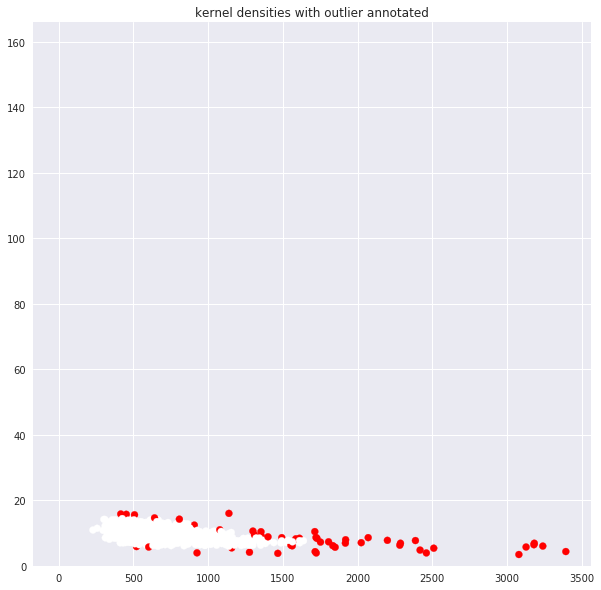

In [30]:
# calculate kernel densities
from scipy import stats
values = np.vstack([C_perstore.ravel(), SC_perstore.ravel()])
kde = stats.gaussian_kde(values)
density = kde(values)

#plot
sns.set(font_scale=1)
plt.figure(figsize=(10,10))
x,y = values

#lowest threshold
n, bins, patches = plt.hist(density, 10)
thres = bins[1]-((bins[1] - bins[0])/2)

#plot the outlier points using the threshold
use_colors = {True:'red', False:'white'}
plt.scatter(x,y, c = [use_colors[x <= thres] for x in density])
plt.title('kernel densities with outlier annotated')
plt.show()

#outliers
outlier_stores = density < thres
data['Outlier'] = pd.Series(outlier_stores, index=data.index)

> Depending of the sales_cust_ratio_threshold, High and Low performing stores are identified

High performers:  $15.64094345825115 - sales/customer,  575.0 - customers
Low performers:  $6.3597060203615445 - sales/customer,  1842.25 - customers
Normal performers:  $9.344202898550725 - sales/customer,  661.0 - customers


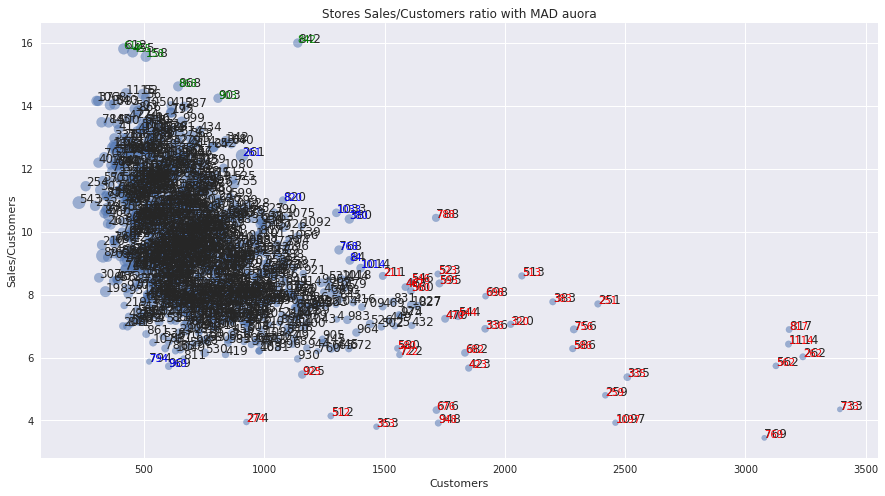

In [31]:
sns.set(font_scale=1)
plt.figure(figsize=(15,8))
plt.scatter(C_perstore, SC_perstore, s=mad_SC_perstore*100, alpha=0.5) 
plt.xlabel('Customers')
plt.ylabel('Sales/Customers')
plt.title('Stores Sales/Customers ratio with MAD auora')
for store in SC_perstore.index:
      plt.annotate(store, (C_perstore[store], SC_perstore[store]))
        
sales_cust_ratio_threshold = [SC_perstore.mean() - 2*SC_perstore.std(), SC_perstore.mean() + 2*SC_perstore.std()] 
cust_threshold = [C_perstore.mean() - 2*C_perstore.std(), C_perstore.mean() + 2*C_perstore.std()]

outlier_annotate = ['n' for x in range(len(outlier_stores))] 
for i, store in enumerate(SC_perstore.index):
    if(outlier_stores[i]):
        # color red if below threshold and color green if above threshold
        if(data['Sales/Customers ratio'][store] <= sales_cust_ratio_threshold[0]
                or data['Customers'][store] >= cust_threshold[1]):
            outlier_annotate[i] = 'l' #lowperformer
            plt.annotate(store, (data['Customers'][store], data['Sales/Customers ratio'][store]), fontsize=10, color='r')
        
        elif (data['Sales/Customers ratio'][store] >= sales_cust_ratio_threshold[1]
                or data['Customers'][store] < cust_threshold[0]):
            outlier_annotate[i] = 'h' #high performer
            plt.annotate(store, (data['Customers'][store], data['Sales/Customers ratio'][store]), fontsize=10, color='g')
        
        else:
            #outlier_annotate[i] = 'n' #normal performer
            plt.annotate(store, (data['Customers'][store], data['Sales/Customers ratio'][store]), fontsize=10, color='b')
               
#
data['Annotation'] = pd.Series(outlier_annotate, index=data.index)
#

# performance measure
hp = data[data['Annotation'] == 'h']['Sales/Customers ratio'].median()
hc = data[data['Annotation'] == 'h']['Customers'].median()
lp = data[data['Annotation'] == 'l']['Sales/Customers ratio'].median()
lc = data[data['Annotation'] == 'l']['Customers'].median()
nop = data[data['Annotation'] == 'n']['Sales/Customers ratio'].median()
nc = data[data['Annotation'] == 'n']['Customers'].median()
print('High performers:  ${} - sales/customer,  {} - customers'.format(hp, hc))
print('Low performers:  ${} - sales/customer,  {} - customers'.format(lp, lc))
print('Normal performers:  ${} - sales/customer,  {} - customers'.format(nop, nc))

In [32]:
data.head()

,Sales/Customers ratio,Customers,Sales/Customers-MAD,Store,Outlier,Annotation
Store,,,,,,
1,8.362376,550.0,0.568739,1,False,n
2,8.313092,575.5,0.777751,2,False,n
3,9.123440,744.0,0.915356,3,False,n
4,7.215175,1301.5,0.403820,4,False,n
5,8.584677,564.0,0.807175,5,False,n


In [33]:
df.head()

,Store,DayOfWeek,Sales,Customers,Promo,StateHoliday,SchoolHoliday,Day,Month,Year,MonthYear,SalesPerCustomer
0,1,5,5263,555,1,0,1,31,7,2015,2015-07,9.482883
1,2,5,6064,625,1,0,1,31,7,2015,2015-07,9.702400
2,3,5,8314,821,1,0,1,31,7,2015,2015-07,10.126675
3,4,5,13995,1498,1,0,1,31,7,2015,2015-07,9.342457
4,5,5,4822,559,1,0,1,31,7,2015,2015-07,8.626118


In [34]:
store = pd.read_csv('store.csv')
store.head(30)

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN
5,6,a,a,310.0,12.0,2013.0,0,NaN,NaN,NaN
6,7,a,c,24000.0,4.0,2013.0,0,NaN,NaN,NaN
7,8,a,a,7520.0,10.0,2014.0,0,NaN,NaN,NaN
8,9,a,c,2030.0,8.0,2000.0,0,NaN,NaN,NaN
9,10,a,a,3160.0,9.0,2009.0,0,NaN,NaN,NaN


In [35]:
store.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1115 entries, 0 to 1114
Data columns (total 10 columns):
Store                        1115 non-null int64
StoreType                    1115 non-null object
Assortment                   1115 non-null object
CompetitionDistance          1112 non-null float64
CompetitionOpenSinceMonth    761 non-null float64
CompetitionOpenSinceYear     761 non-null float64
Promo2                       1115 non-null int64
Promo2SinceWeek              571 non-null float64
Promo2SinceYear              571 non-null float64
PromoInterval                571 non-null object
dtypes: float64(5), int64(2), object(3)
memory usage: 87.2+ KB


In [36]:
store.isnull().sum()

Store                          0
StoreType                      0
Assortment                     0
CompetitionDistance            3
CompetitionOpenSinceMonth    354
CompetitionOpenSinceYear     354
Promo2                         0
Promo2SinceWeek              544
Promo2SinceYear              544
PromoInterval                544
dtype: int64

In [37]:
store['CompetitionDistance'] = store['CompetitionDistance'].fillna(store['CompetitionDistance'].median())
store['CompetitionOpenSinceMonth'] = store['CompetitionOpenSinceMonth'].fillna(store['CompetitionOpenSinceMonth'].mode().iloc[0]) #try 0
store['CompetitionOpenSinceYear'] = store['CompetitionOpenSinceYear'].fillna(store['CompetitionOpenSinceYear'].mode().iloc[0]) #try 0
store['Promo2SinceWeek'] = store['Promo2SinceWeek'].fillna(store['Promo2SinceWeek'].mode().iloc[0]) 
store['Promo2SinceYear'] = store['Promo2SinceYear'].fillna(store['Promo2SinceYear'].mode().iloc[0]) 
store['PromoInterval'] = store['PromoInterval'].fillna(store['PromoInterval'].mode().iloc[0]) 

store = store.astype({"CompetitionDistance": int, "CompetitionOpenSinceMonth": int, "CompetitionOpenSinceYear": int, "Promo2SinceWeek": int, "Promo2SinceYear": int})

store.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1115 entries, 0 to 1114
Data columns (total 10 columns):
Store                        1115 non-null int64
StoreType                    1115 non-null object
Assortment                   1115 non-null object
CompetitionDistance          1115 non-null int64
CompetitionOpenSinceMonth    1115 non-null int64
CompetitionOpenSinceYear     1115 non-null int64
Promo2                       1115 non-null int64
Promo2SinceWeek              1115 non-null int64
Promo2SinceYear              1115 non-null int64
PromoInterval                1115 non-null object
dtypes: int64(7), object(3)
memory usage: 87.2+ KB


In [38]:
store.head()


,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270,9,2008,0,14,2011,"Jan,Apr,Jul,Oct"
1,2,a,a,570,11,2007,1,13,2010,"Jan,Apr,Jul,Oct"
2,3,a,a,14130,12,2006,1,14,2011,"Jan,Apr,Jul,Oct"
3,4,c,c,620,9,2009,0,14,2011,"Jan,Apr,Jul,Oct"
4,5,a,a,29910,4,2015,0,14,2011,"Jan,Apr,Jul,Oct"


In [39]:
store.index.name = None
data.index.name = None

stores_update = store.merge(data, how='left', on='Store')
stores_update

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,Sales/Customers ratio,Customers,Sales/Customers-MAD,Outlier,Annotation
0,1,c,a,1270,9,2008,0,14,2011,"Jan,Apr,Jul,Oct",8.362376,550.0,0.568739,False,n
1,2,a,a,570,11,2007,1,13,2010,"Jan,Apr,Jul,Oct",8.313092,575.5,0.777751,False,n
2,3,a,a,14130,12,2006,1,14,2011,"Jan,Apr,Jul,Oct",9.123440,744.0,0.915356,False,n
3,4,c,c,620,9,2009,0,14,2011,"Jan,Apr,Jul,Oct",7.215175,1301.5,0.403820,False,n
4,5,a,a,29910,4,2015,0,14,2011,"Jan,Apr,Jul,Oct",8.584677,564.0,0.807175,False,n
5,6,a,a,310,12,2013,0,14,2011,"Jan,Apr,Jul,Oct",8.640966,634.5,0.563703,False,n
6,7,a,c,24000,4,2013,0,14,2011,"Jan,Apr,Jul,Oct",9.121255,938.5,0.716003,False,n
7,8,a,a,7520,10,2014,0,14,2011,"Jan,Apr,Jul,Oct",8.183258,672.5,0.800002,False,n
8,9,a,c,2030,8,2000,0,14,2011,"Jan,Apr,Jul,Oct",11.136029,561.0,0.754183,False,n
9,10,a,a,3160,9,2009,0,14,2011,"Jan,Apr,Jul,Oct",9.291217,588.0,0.604193,False,n


> Distribution of StoreType across High, Low and Normal performers

In [40]:
storetype = stores_update.groupby('Annotation')['StoreType'].value_counts().sort_index()
s = storetype.unstack()
s[s.isnull()]=0
#for each annotation calculate normalised value_counts
for st in s.index:
    s.loc[st]  = s.loc[st]/s.loc[st].sum()
 
    
s[s.isnull()]=0  # convert all NAN to 0  
storetype = s
storetype

StoreType,a,b,c,d
Annotation,,,,
h,0.000000,0.000000,0.000000,1.000000
l,0.500000,0.388889,0.111111,0.000000
n,0.544268,0.002796,0.134203,0.318733


> Distribution of Assortment across High, Low and Normal performers

In [41]:
assort = stores_update.groupby('Annotation')['Assortment'].value_counts().sort_index()
s = assort.unstack()
s[s.isnull()]=0
for st in s.index:
    s.loc[st]  = s.loc[st]/s.loc[st].sum()
s[s.isnull()]=0   
assort = s

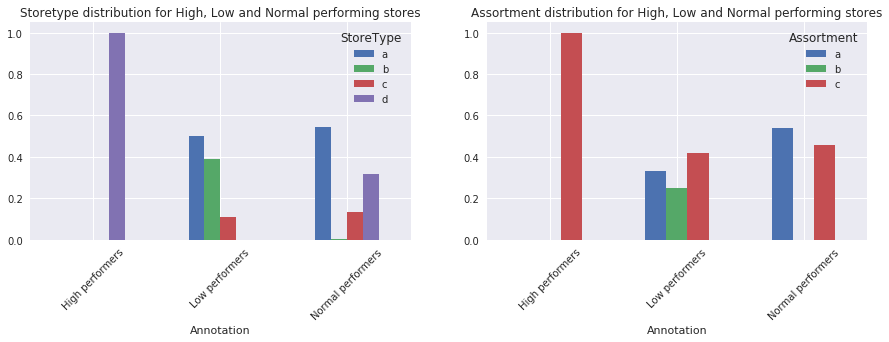

In [42]:
#plot
sns.set(font_scale=1)
fig, (axis1, axis2) = plt.subplots(1,2, figsize=(15,4))
ax = storetype.plot(kind='bar', rot=45, ax=axis1)
tmp = ax.set_xticklabels(['High performers', 'Low performers', 'Normal performers'])
tmp = ax.set_title('Storetype distribution for High, Low and Normal performing stores')
ax1 = assort.plot(kind='bar', rot=45, ax=axis2)
tmp = ax1.set_xticklabels(['High performers', 'Low performers', 'Normal performers'])
tmp = ax1.set_title('Assortment distribution for High, Low and Normal performing stores')


> Distribution of Competition Distance across High, Low and Normal performers

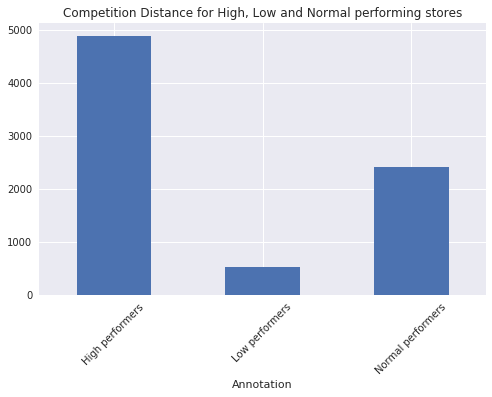

In [43]:
sns.set(font_scale=1)
fig, (axis1) = plt.subplots(1,1, figsize=(8,5))
compdist = stores_update.groupby('Annotation')['CompetitionDistance'].median()
ax2 = compdist.plot(kind='bar', rot=45, ax=axis1)
tmp = ax2.set_xticklabels(['High performers', 'Low performers', 'Normal performers'])
tmp = ax2.set_title('Competition Distance for High, Low and Normal performing stores')

In [44]:
df_store = store.merge(df, how='left', on='Store')

In [45]:
df_store.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,...,Sales,Customers,Promo,StateHoliday,SchoolHoliday,Day,Month,Year,MonthYear,SalesPerCustomer
0,1,c,a,1270,9,2008,0,14,2011,"Jan,Apr,Jul,Oct",...,5263,555,1,0,1,31,7,2015,2015-07,9.482883
1,1,c,a,1270,9,2008,0,14,2011,"Jan,Apr,Jul,Oct",...,5020,546,1,0,1,30,7,2015,2015-07,9.194139
2,1,c,a,1270,9,2008,0,14,2011,"Jan,Apr,Jul,Oct",...,4782,523,1,0,1,29,7,2015,2015-07,9.143403
3,1,c,a,1270,9,2008,0,14,2011,"Jan,Apr,Jul,Oct",...,5011,560,1,0,1,28,7,2015,2015-07,8.948214
4,1,c,a,1270,9,2008,0,14,2011,"Jan,Apr,Jul,Oct",...,6102,612,1,0,1,27,7,2015,2015-07,9.970588


> Distribution of Sales depending on the promos offered

<Figure size 1440x576 with 0 Axes>

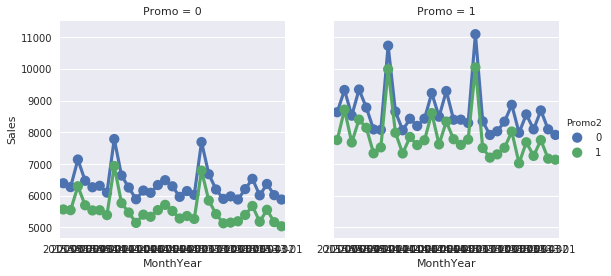

In [46]:
plt.figure(figsize = (20,8))

sns.factorplot(data = df_store, x ="MonthYear", y = "Sales", 
               col = 'Promo', # per store type in cols
               hue = 'Promo2'
              ,sharex=False)

> Combining CompetitionOpenSinceYear and CompetitionOpenSinceMonth into one feature 'CompetitionOpenSince

In [47]:
df_store['CompetitionOpenSince'] = np.where((df_store['CompetitionOpenSinceMonth']==0) & (df_store['CompetitionOpenSinceYear']==0) , 0,(df_store.Month - df_store.CompetitionOpenSinceMonth) + 
                                       (12 * (df_store.Year - df_store.CompetitionOpenSinceYear)) )

del df_store['CompetitionOpenSinceYear']
del df_store['CompetitionOpenSinceMonth']

In [48]:
df_store.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 844340 entries, 0 to 844339
Data columns (total 20 columns):
Store                   844340 non-null int64
StoreType               844340 non-null object
Assortment              844340 non-null object
CompetitionDistance     844340 non-null int64
Promo2                  844340 non-null int64
Promo2SinceWeek         844340 non-null int64
Promo2SinceYear         844340 non-null int64
PromoInterval           844340 non-null object
DayOfWeek               844340 non-null int64
Sales                   844340 non-null int64
Customers               844340 non-null int64
Promo                   844340 non-null int64
StateHoliday            844340 non-null object
SchoolHoliday           844340 non-null int64
Day                     844340 non-null int64
Month                   844340 non-null int64
Year                    844340 non-null int64
MonthYear               844340 non-null object
SalesPerCustomer        844340 non-null float64
Competit

##### Encoding categorical features 

In [49]:
df_store['StoreType'] = df_store['StoreType'].map({'a':1 , 'b':2 , 'c':3 , 'd':4})
df_store['StoreType'] = df_store['StoreType'].astype(int)

In [50]:
df_store['Assortment'] = df_store['Assortment'].map({'a':1 , 'b':2 , 'c':3})
df_store['Assortment'] = df_store['Assortment'].astype(int)

In [51]:
df_store['PromoInterval'] = df_store['PromoInterval'].map({'Jan,Apr,Jul,Oct':1 , 'Feb,May,Aug,Nov':2 , 'Mar,Jun,Sept,Dec':3})
df_store['PromoInterval'] = df_store['PromoInterval'].astype(int)

In [52]:
df_store['StateHoliday'] = df_store['StateHoliday'].map({'0':0 , 'a':1 , 'b':2 , 'c':3})
df_store['StateHoliday'] = df_store['StateHoliday'].astype(int)

In [53]:
df_store.isnull().sum()

Store                   0
StoreType               0
Assortment              0
CompetitionDistance     0
Promo2                  0
Promo2SinceWeek         0
Promo2SinceYear         0
PromoInterval           0
DayOfWeek               0
Sales                   0
Customers               0
Promo                   0
StateHoliday            0
SchoolHoliday           0
Day                     0
Month                   0
Year                    0
MonthYear               0
SalesPerCustomer        0
CompetitionOpenSince    0
dtype: int64

In [54]:
df_store.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 844340 entries, 0 to 844339
Data columns (total 20 columns):
Store                   844340 non-null int64
StoreType               844340 non-null int64
Assortment              844340 non-null int64
CompetitionDistance     844340 non-null int64
Promo2                  844340 non-null int64
Promo2SinceWeek         844340 non-null int64
Promo2SinceYear         844340 non-null int64
PromoInterval           844340 non-null int64
DayOfWeek               844340 non-null int64
Sales                   844340 non-null int64
Customers               844340 non-null int64
Promo                   844340 non-null int64
StateHoliday            844340 non-null int64
SchoolHoliday           844340 non-null int64
Day                     844340 non-null int64
Month                   844340 non-null int64
Year                    844340 non-null int64
MonthYear               844340 non-null object
SalesPerCustomer        844340 non-null float64
CompetitionO

In [55]:
df_store.drop(['MonthYear'], inplace = True, axis = 1)

In [56]:
test_store = pd.merge(test, store, how = 'left', on = 'Store')
test_store.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41077 entries, 0 to 41076
Data columns (total 19 columns):
Store                        41077 non-null int64
DayOfWeek                    41077 non-null int64
Open                         41077 non-null int64
Promo                        41077 non-null int64
StateHoliday                 41077 non-null object
SchoolHoliday                41077 non-null int64
Day                          41077 non-null int64
Month                        41077 non-null int64
Year                         41077 non-null int64
MonthYear                    41077 non-null object
StoreType                    41077 non-null object
Assortment                   41077 non-null object
CompetitionDistance          41077 non-null int64
CompetitionOpenSinceMonth    41077 non-null int64
CompetitionOpenSinceYear     41077 non-null int64
Promo2                       41077 non-null int64
Promo2SinceWeek              41077 non-null int64
Promo2SinceYear              41077 no

In [57]:
test_store['Open'].unique()

array([1, 0])

In [58]:
test_store = test_store.drop(test_store[(test_store.Open == 0)].index)

In [59]:
test_store.fillna(method='ffill', inplace=True)

In [60]:
test_store.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 35093 entries, 0 to 41076
Data columns (total 19 columns):
Store                        35093 non-null int64
DayOfWeek                    35093 non-null int64
Open                         35093 non-null int64
Promo                        35093 non-null int64
StateHoliday                 35093 non-null object
SchoolHoliday                35093 non-null int64
Day                          35093 non-null int64
Month                        35093 non-null int64
Year                         35093 non-null int64
MonthYear                    35093 non-null object
StoreType                    35093 non-null object
Assortment                   35093 non-null object
CompetitionDistance          35093 non-null int64
CompetitionOpenSinceMonth    35093 non-null int64
CompetitionOpenSinceYear     35093 non-null int64
Promo2                       35093 non-null int64
Promo2SinceWeek              35093 non-null int64
Promo2SinceYear              35093 no

In [61]:
test_store.drop(['Open','MonthYear'], inplace = True, axis = 1)
test_store.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 35093 entries, 0 to 41076
Data columns (total 17 columns):
Store                        35093 non-null int64
DayOfWeek                    35093 non-null int64
Promo                        35093 non-null int64
StateHoliday                 35093 non-null object
SchoolHoliday                35093 non-null int64
Day                          35093 non-null int64
Month                        35093 non-null int64
Year                         35093 non-null int64
StoreType                    35093 non-null object
Assortment                   35093 non-null object
CompetitionDistance          35093 non-null int64
CompetitionOpenSinceMonth    35093 non-null int64
CompetitionOpenSinceYear     35093 non-null int64
Promo2                       35093 non-null int64
Promo2SinceWeek              35093 non-null int64
Promo2SinceYear              35093 non-null int64
PromoInterval                35093 non-null object
dtypes: int64(13), object(4)
memory u

## Predictive Model

### Random Forest Regressor

In [62]:
X = df_store.drop(['Sales','Customers', 'SalesPerCustomer'], axis = 1)
#Transform Target Variable
y = np.log1p(df_store['Sales'])

from sklearn.model_selection import train_test_split
X_train , X_val , y_train , y_val = train_test_split(X, y , test_size=0.30 , random_state = 1 )

X_train.shape, X_val.shape, y_train.shape, y_val.shape

((591038, 16), (253302, 16), (591038,), (253302,))

In [63]:
def rmspe(y, yhat):
    rmspe = np.sqrt(np.mean( (y - yhat)**2 ))
    return rmspe

In [64]:
#with optimal parameters
rfr_val=RandomForestRegressor(n_estimators=72, 
                             criterion='mse', 
                             max_depth=20, 
                             min_samples_split=10, 
                             min_samples_leaf=1, 
                             min_weight_fraction_leaf=0.0, 
                             max_features='auto', 
                             max_leaf_nodes=None, 
                             min_impurity_decrease=0.0, 
                             min_impurity_split=None, 
                             bootstrap=True, 
                             oob_score=False,
                             n_jobs=4, 
                             random_state=35, 
                             verbose=0, 
                             warm_start=False)
model_RF_test=rfr_val.fit(X_train,y_train)

In [65]:
X_train

,Store,StoreType,Assortment,CompetitionDistance,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,DayOfWeek,Promo,StateHoliday,SchoolHoliday,Day,Month,Year,CompetitionOpenSince
788974,1043,3,1,420,0,14,2011,1,6,0,0,0,8,11,2014,104
88579,118,4,3,3580,0,14,2011,1,3,1,0,0,21,5,2014,20
247584,328,1,1,3130,0,14,2011,1,2,0,0,1,2,4,2013,129
341255,451,1,1,2460,1,13,2010,1,2,1,0,0,18,2,2014,58
359978,475,1,1,140,0,14,2011,1,6,0,0,0,22,6,2013,93
278950,369,4,3,5870,0,14,2011,1,5,0,0,0,4,10,2013,-6
642463,849,3,3,5000,0,14,2011,1,4,0,0,1,27,6,2013,-3
730609,966,1,1,760,0,14,2011,1,4,0,0,1,23,7,2015,89
520103,688,1,1,18760,1,14,2011,1,3,1,0,0,18,2,2015,-6
52085,69,3,3,1130,1,40,2011,1,3,0,0,0,12,6,2013,-3


In [66]:
len(X_train.columns)

16

In [67]:
model_RF_test

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=20,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=10,
           min_weight_fraction_leaf=0.0, n_estimators=72, n_jobs=4,
           oob_score=False, random_state=35, verbose=0, warm_start=False)

In [68]:
y_pred = model_RF_test.predict(X_val)

(array([4.40000e+01, 2.89000e+02, 1.35000e+03, 7.88800e+03, 3.90530e+04,
        1.05307e+05, 7.81520e+04, 1.75950e+04, 3.38900e+03, 2.35000e+02]),
 array([ 6.48692838,  6.88154833,  7.27616828,  7.67078824,  8.06540819,
         8.46002814,  8.8546481 ,  9.24926805,  9.64388801, 10.03850796,
        10.43312791]),
 <a list of 10 Patch objects>)

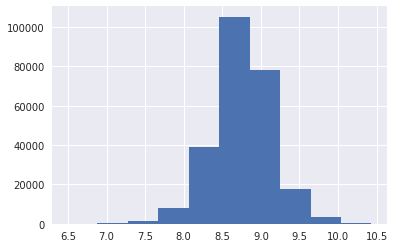

In [69]:
plt.hist(y_pred)

In [70]:
error = rmspe(y_val, y_pred)
error

0.16939006133865356

### Feature Importance

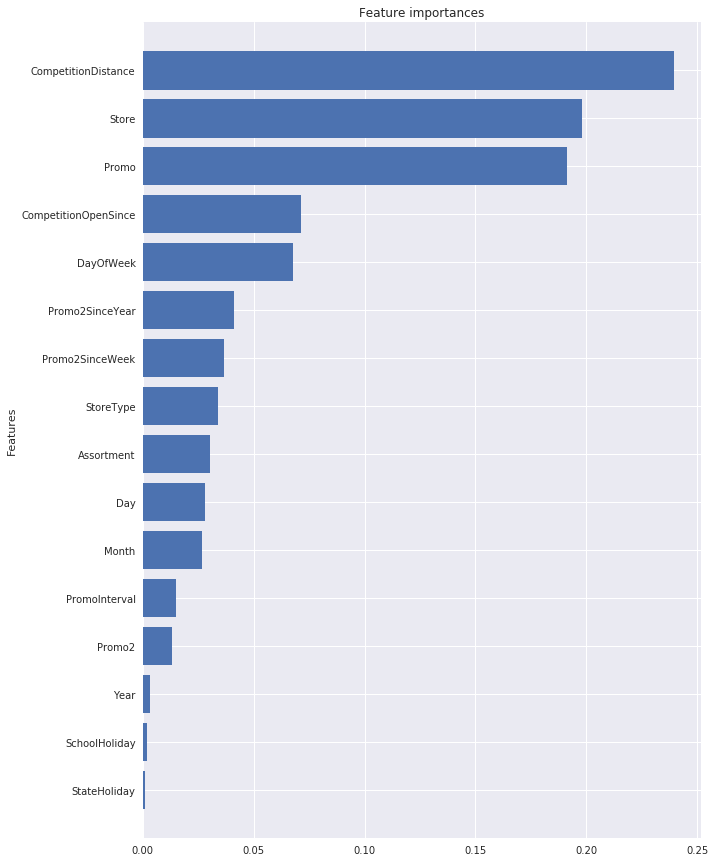

In [71]:
import itertools
importances = rfr_val.feature_importances_
std = np.std([rfr_val.feature_importances_ for tree in rfr_val.estimators_],
             axis=0)
indices = np.argsort(importances)

features_ranked=[]
for f in range(X_train.shape[1]):
    features_ranked.append(X_train.columns[indices[f]])
#features_ranked = features_ranked[::-1]
#print("Importance of Features:\n\n", features_ranked)

#Plot of the feature importances 
plt.figure(figsize = (10,15))
plt.title("Feature importances")
plt.barh(range(X_train.shape[1]), importances[indices], align = "center")
plt.yticks(range(X_train.shape[1]), features_ranked)
plt.ylabel('Features')
plt.ylim([-1, X_train.shape[1]])
plt.show()


### Model Prediction

In [72]:
df1 = pd.DataFrame({'Actual': y_val, 'Predicted': y_pred})
df1.head(25)

,Actual,Predicted
800327,9.087042,9.025985
356432,8.762020,8.625915
64656,8.213924,8.211078
620624,8.731498,8.946155
760064,8.315322,8.423123
457213,8.619389,8.511104
579972,8.962648,8.523318
760589,9.148252,9.112181
792640,8.614683,8.586502
490890,8.156510,8.085717


In [73]:
test_store.loc[1:]

,Store,DayOfWeek,Promo,StateHoliday,SchoolHoliday,Day,Month,Year,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
1,3,4,1,0,0,17,9,2015,a,a,14130,12,2006,1,14,2011,"Jan,Apr,Jul,Oct"
2,7,4,1,0,0,17,9,2015,a,c,24000,4,2013,0,14,2011,"Jan,Apr,Jul,Oct"
3,8,4,1,0,0,17,9,2015,a,a,7520,10,2014,0,14,2011,"Jan,Apr,Jul,Oct"
4,9,4,1,0,0,17,9,2015,a,c,2030,8,2000,0,14,2011,"Jan,Apr,Jul,Oct"
5,10,4,1,0,0,17,9,2015,a,a,3160,9,2009,0,14,2011,"Jan,Apr,Jul,Oct"
6,11,4,1,0,0,17,9,2015,a,c,960,11,2011,1,1,2012,"Jan,Apr,Jul,Oct"
7,12,4,1,0,0,17,9,2015,a,c,1070,9,2013,1,13,2010,"Jan,Apr,Jul,Oct"
8,13,4,1,0,0,17,9,2015,d,a,310,9,2013,1,45,2009,"Feb,May,Aug,Nov"
9,14,4,1,0,0,17,9,2015,a,a,1300,3,2014,1,40,2011,"Jan,Apr,Jul,Oct"
10,15,4,1,0,0,17,9,2015,d,c,4110,3,2010,1,14,2011,"Jan,Apr,Jul,Oct"


## END